In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

tf.random.set_seed(12)

In [2]:
# # Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.10.0


### Define PINN

In [5]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(1))

        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))

        model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))

        return model
    
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = self.init_model()
        
        self.iter = 1
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        xx = self.Xr_tf*self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)       
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1, loss_2, loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        del tape 
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5000 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
#             if i%10000 == 0:
#                 self.weights_log.append(PINN_solver.model.get_weights())
#                 self.gradients_log.append([grad_theta, g_u, g_r])
                
    def predict(self, x_star):
        mu, sigma = self.mu_x, self.sigma_x
        x_star_normalized = (x_star-mu)/sigma
        
        return self.model(x_star_normalized)

### Generate training data

In [6]:
# Number of training data
N_u = 1                          # Boundary condition data on u(x)  
N_r = 300                        # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])            # Left boundary of the domain
ub  = np.array([300.0])          # Right boundary of the domain

# Define the initial MSS state
x_u = np.array([[0]])
y_u = np.array([[1,0,0]])          # Solution at boundary points
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points

In [7]:
N = 150000 ## N is the number of epoches to train PINN

### Train PINN without PCGrad

In [8]:
#学习率调度器，在训练过程中以多项式方式衰减学习率，跟几乎当前的训练步数计算学习率，使学习率逐渐减小
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, #初始学习率为0.001，衰减步数为10000（10000步以后学习率从初始值衰减到终止值）
    end_learning_rate=0.00008, power=0.5) #终止学习率为0.00008，衰减方式为0.5次方衰减

In [9]:
PINN_solver = PINN(x_u, y_u, x_r)
initial_weights = PINN_solver.model.get_weights()

In [10]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 05000: loss = 6.785056e-06,1.418412e-05,4.5482157e-06,1.0849036e-05
Iteration 10000: loss = 4.0339532e-06,1.00988445e-05,2.328987e-06,4.0402047e-06
Iteration 15000: loss = 8.3628646e-07,6.4445453e-07,4.8648633e-07,2.0838024e-07
Iteration 20000: loss = 9.157082e-08,7.575166e-08,3.8024364e-08,2.4371245e-08
Iteration 25000: loss = 2.1319659e-08,1.7382424e-08,5.187046e-09,6.1059535e-09
Iteration 30000: loss = 8.962996e-09,7.1308404e-09,1.910615e-09,2.4755182e-09
Iteration 35000: loss = 5.378718e-09,4.196236e-09,1.1412141e-09,1.5666857e-09
Iteration 40000: loss = 3.9096757e-09,2.9720084e-09,7.7446655e-10,1.1297847e-09
Iteration 45000: loss = 3.0855372e-09,2.3410478e-09,5.6301463e-10,8.8969526e-10
Iteration 50000: loss = 2.540432e-09,1.9560296e-09,4.4025134e-10,7.3570766e-10
Iteration 55000: loss = 2.189245e-09,1.6847497e-09,3.5818903e-10,6.3804073e-10
Iteration 60000: loss = 1.935086e-09,1.4778234e-09,3.0430808e-10,5.561405e-10
Iteration 65000: loss = 1.7058336e-09,1.3389251e-09,2

### Train PINN with PCGrad

In [11]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r)
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [12]:
%%time

optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 05000: loss = 5.5591677e-06,4.9328246e-06,5.1433863e-06,8.6147327e-07
Iteration 10000: loss = 1.3890208e-06,2.2973303e-08,1.6108597e-08,6.046015e-09
Iteration 15000: loss = 3.2244648e-07,1.714712e-08,1.0426952e-08,5.42207e-09
Iteration 20000: loss = 7.302105e-08,5.801483e-09,3.5737378e-09,2.4412872e-09
Iteration 25000: loss = 1.1247358e-08,5.679022e-09,2.688246e-09,2.1953046e-09
Iteration 30000: loss = 2.496882e-09,5.8619625e-09,2.0701658e-09,1.9589588e-09
Iteration 35000: loss = 1.1340332e-09,4.8560236e-09,1.5018313e-09,1.5762254e-09
Iteration 40000: loss = 7.37915e-10,3.922867e-09,1.1204461e-09,1.2924225e-09
Iteration 45000: loss = 6.5365596e-10,2.8887217e-09,8.126567e-10,9.871925e-10
Iteration 50000: loss = 4.2404746e-10,2.7351745e-09,7.4294715e-10,9.3049596e-10
Iteration 55000: loss = 3.0513303e-10,2.5392064e-09,6.786423e-10,8.58495e-10
Iteration 60000: loss = 3.2284944e-10,1.978264e-09,5.256184e-10,6.911173e-10
Iteration 65000: loss = 1.8886688e-10,2.2199094e-09,5.711257

### Visualize loss function

In [13]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Comparison of loss 

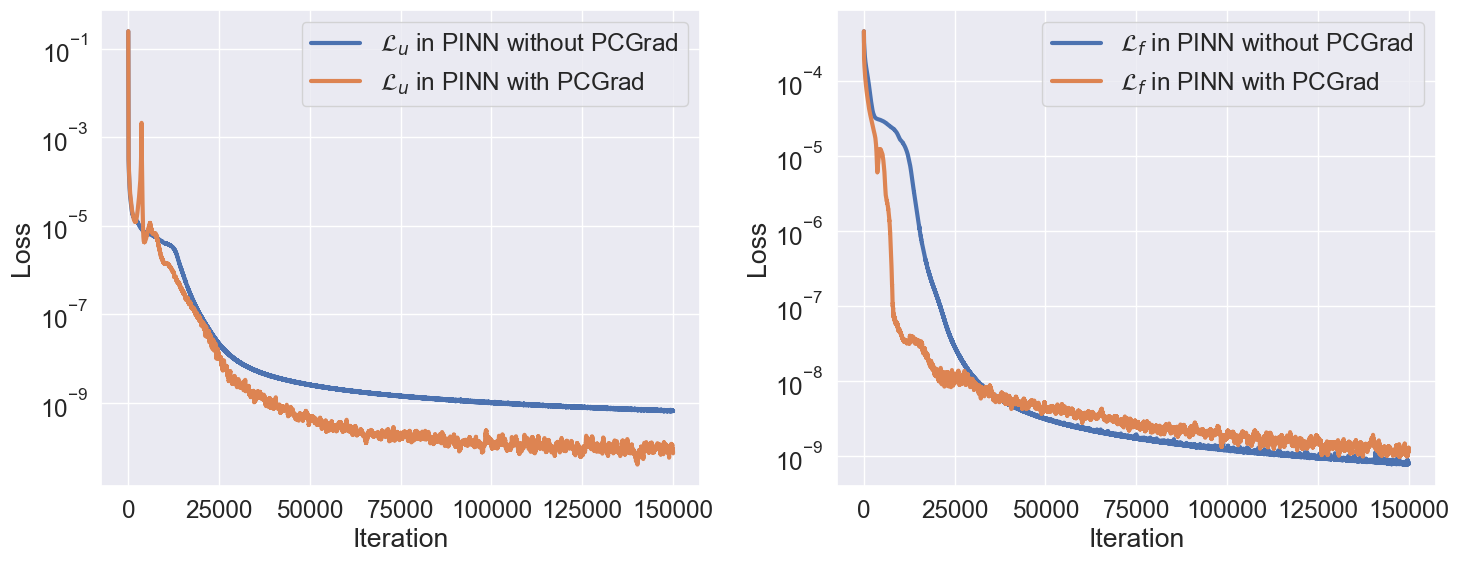

In [14]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = np.sum(pinn_loss_log[:, 1:4], axis = 1).flatten(),  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = np.sum(pinn_pcgrad_loss_log[:, 1:4], axis = 1).flatten(), 
             linewidth = 3, label = "$\mathcal{L}_f$ in PINN with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("performance_comparison_non_homo.pdf")

### Solution quality comparison

#### Load solver solution

In [15]:
matlab_solver_solution_df = pd.read_csv('non_homo_300.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [16]:
matlab_solver_solution_df.head()

,time,state_0,state_1,state_2
0,1,0.99904,0.000418,0.000544
1,2,0.99808,0.000837,0.001087
2,3,0.99711,0.001255,0.001631
3,4,0.99615,0.001674,0.002175
4,5,0.99519,0.002092,0.002718


In [17]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [18]:
matlab_solver_solution_df.head()

,state_0,state_1,state_2
0,0.99904,0.000418,0.000544
1,0.99808,0.000837,0.001087
2,0.99711,0.001255,0.001631
3,0.99615,0.001674,0.002175
4,0.99519,0.002092,0.002718


#### Load MCS solution

In [19]:
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [20]:
MCS_solution_df.head()

,time,state_0,state_1,state_2
0,1.0,0.999875,0.000050,0.000075
1,2.0,0.999505,0.000217,0.000279
2,3.0,0.998871,0.000483,0.000646
3,4.0,0.997994,0.000869,0.001137
4,5.0,0.996878,0.001357,0.001765


In [21]:
MCS_solution_df.drop(labels='time', inplace=True, axis = 1)

In [22]:
MCS_solution_df.head()

,state_0,state_1,state_2
0,0.999875,0.000050,0.000075
1,0.999505,0.000217,0.000279
2,0.998871,0.000483,0.000646
3,0.997994,0.000869,0.001137
4,0.996878,0.001357,0.001765


#### PINN Solver

In [23]:
n_star = 300+1
x_star = np.linspace(lb, ub, n_star)[1:]

In [24]:
%%time

y_pred = PINN_solver.predict(x_star)
y_pred_pcgrad = PINN_solver_pcgrad.predict(x_star)

CPU times: total: 15.6 ms
Wall time: 15 ms


In [25]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

#### Compare PINN predictions with Matlab solver

In [26]:
sns.set_style("white")
plt.rcParams['legend.fontsize'] = 12

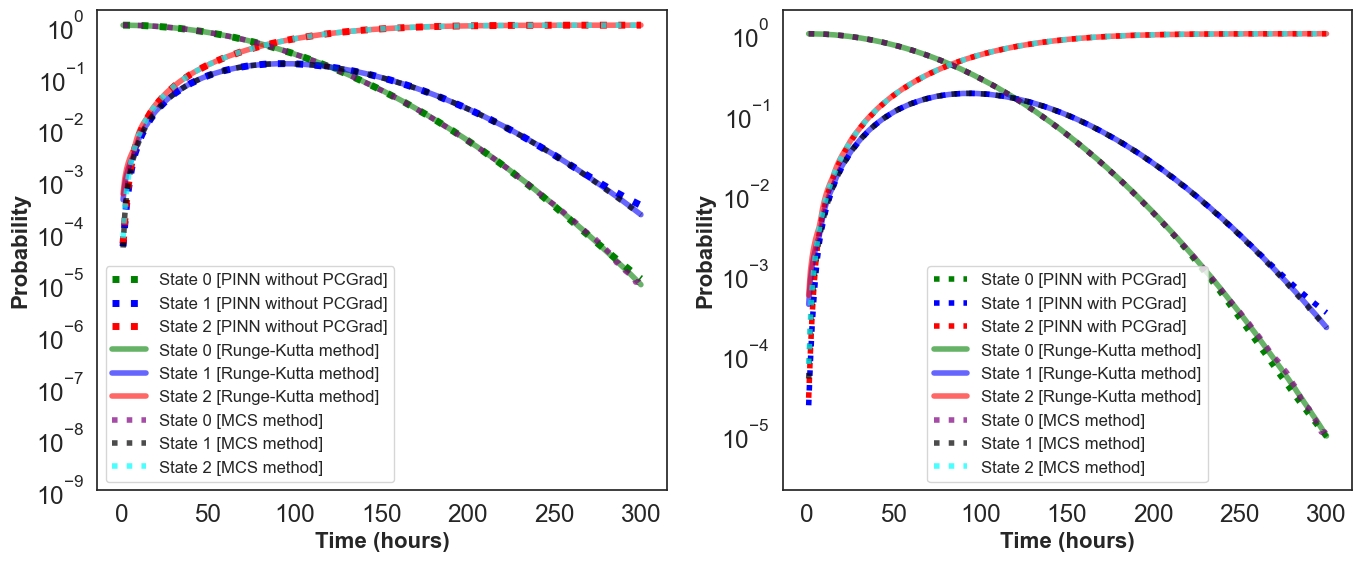

In [27]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0 [PINN without PCGrad]', linewidth = 5, color = 'green', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1 [PINN without PCGrad]', linewidth = 5, color = 'blue', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2 [PINN without PCGrad]', linewidth = 5, color = 'red', 
             linestyle='dotted', ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta method]', color = 'green',
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta method]', color = 'blue', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta method]', color = 'red', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_0'], 
             label = 'State 0 [MCS method]', color = 'purple', linestyle='dotted',
             alpha=0.7, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_1'], 
             label = 'State 1 [MCS method]', color = 'black', linestyle='dotted',
             alpha=0.7, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_2'], 
             label = 'State 2 [MCS method]', color = 'cyan', linestyle='dotted',
             alpha=0.7,  linewidth = 4, ax=ax[0])

ax[0].set_yscale("log")
ax[0].set_ylim([1e-9, 2])
ax[0].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[0].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'State 0 [PINN with PCGrad]', 
             color = 'green', linestyle='dotted', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'State 1 [PINN with PCGrad]', 
             color = 'blue', linestyle='dotted', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'State 2 [PINN with PCGrad]', 
             color = 'red', linestyle='dotted', linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta method]', color = 'green',
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta method]', color = 'blue', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta method]', color = 'red', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_0'], 
             label = 'State 0 [MCS method]', color = 'purple', linestyle='dotted',
             alpha=0.7, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_1'], 
             label = 'State 1 [MCS method]', color = 'black', linestyle='dotted',
             alpha=0.7, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_2'], 
             label = 'State 2 [MCS method]', color = 'cyan', linestyle='dotted',
             alpha=0.7,  linewidth = 4, ax=ax[1])

ax[1].set_yscale("log")
ax[1].set_ylim([2*1e-6, 2])
ax[1].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[1].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout()
plt.savefig("comparison_non_homo.pdf")

#### Calculate the RMSE 

- between MCS and the Runge-Kutta method
- between MCS and PINN with PCGrad and without PCGrad
- between the Runge-Kutta method and PINN with PCGrad and without PCGrad

In [28]:
y_diff_matlab = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad_matlab = matlab_solver_solution_df - y_pred_pcgrad_df

y_diff_MCS = MCS_solution_df - y_pred_df
y_diff_pcgrad_MCS = MCS_solution_df - y_pred_pcgrad_df

y_diff_MCS_matlab = MCS_solution_df - matlab_solver_solution_df

In [29]:
y_diff_matlab['mse'] = y_diff_matlab.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_matlab['rmse'] = y_diff_matlab['mse'].apply(np.sqrt)

y_diff_pcgrad_matlab['mse'] = y_diff_pcgrad_matlab.apply(lambda x: x['state_0']**2 + x['state_1']**2 + \
                                                         x['state_2']**2, axis = 1)
y_diff_pcgrad_matlab['rmse'] = y_diff_pcgrad_matlab['mse'].apply(np.sqrt)

In [30]:
y_diff_MCS['mse'] = y_diff_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_MCS['rmse'] = y_diff_MCS['mse'].apply(np.sqrt)

y_diff_pcgrad_MCS['mse'] = y_diff_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad_MCS['rmse'] = y_diff_pcgrad_MCS['mse'].apply(np.sqrt)

In [31]:
y_diff_MCS_matlab['mse'] = y_diff_MCS_matlab.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_MCS_matlab['rmse'] = y_diff_MCS_matlab['mse'].apply(np.sqrt)

In [32]:
print ('RMSE between PINN without PCGrad and the Runge-Kutta method is', np.mean(y_diff_matlab['rmse']))
print ('RMSE between PINN with PCGrad and the Runge-Kutta method is', np.mean(y_diff_pcgrad_matlab['rmse']))

print ('RMSE of between PINN without PCGrad and MCS simulations is', np.mean(y_diff_MCS['rmse']))
print ('RMSE of between PINN with PCGrad and MCS simulations is', np.mean(y_diff_pcgrad_MCS['rmse']))

print ('RMSE of between MCS and the Runge-Kutta method is', np.mean(y_diff_MCS_matlab['rmse']))

RMSE between PINN without PCGrad and the Runge-Kutta method is 0.000520969515240303
RMSE between PINN with PCGrad and the Runge-Kutta method is 0.0006078604687317566
RMSE of between PINN without PCGrad and MCS simulations is 0.0003799211722506121
RMSE of between PINN with PCGrad and MCS simulations is 0.000614948108846564
RMSE of between MCS and the Runge-Kutta method is 0.000575281122952207


#### Generate the histogram of prediction difference with respect to each state

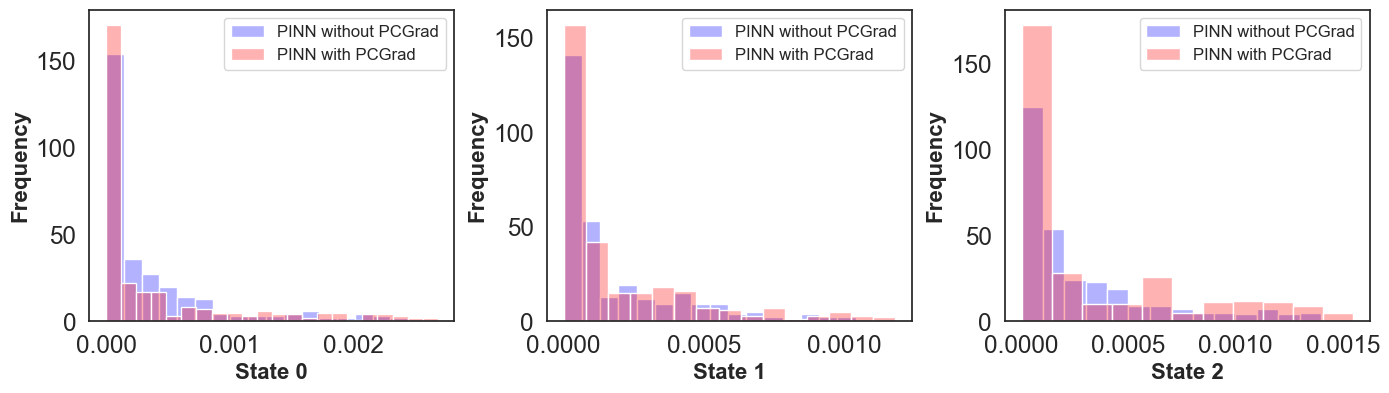

In [33]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(np.abs(y_diff_matlab['state_0']), ax=axes[0], alpha =0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['state_0']), ax=axes[0], alpha =0.3, color='red', label='PINN with PCGrad')

axes[0].legend()
axes[0].set_xlabel('State 0', fontdict=dict(weight='bold'), fontsize=16)
axes[0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff_matlab['state_1']), ax=axes[1], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['state_1']), alpha=0.3, ax=axes[1], color='red', label='PINN with PCGrad')
axes[1].legend()
axes[1].set_xlabel('State 1', fontdict=dict(weight='bold'), fontsize=16)
axes[1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff_matlab['state_2']), ax=axes[2], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['state_2']), alpha=0.3, ax=axes[2], color='red', label='PINN with PCGrad')
axes[2].legend()
axes[2].set_xlabel('State 2', fontdict=dict(weight='bold'), fontsize=16)
axes[2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout(pad=0.5)
plt.savefig("histogram_small_non_homo.pdf")